<h3>Data Wrangling with MongoDB: Final Project</h3>

<h2>Data Wrangling OpenStreetMap Data of a part Sacramento, California</h2>

The area I chose to look at is a subarea of Sacramento, CA where I've spend most of my life, either going to middle school, high school, or college (at California State University of Sacramento). The map data I am using is from OpenStreetMap. It can be downloaded using the Overpass API in XML format. I will be applying the techniques I learned from Udacity's Data Wrangling with MongoDB to explore, audit, and clean the dataset then convert the xml to JSON. 

Sacramento, CA is shown as the selected box region below:

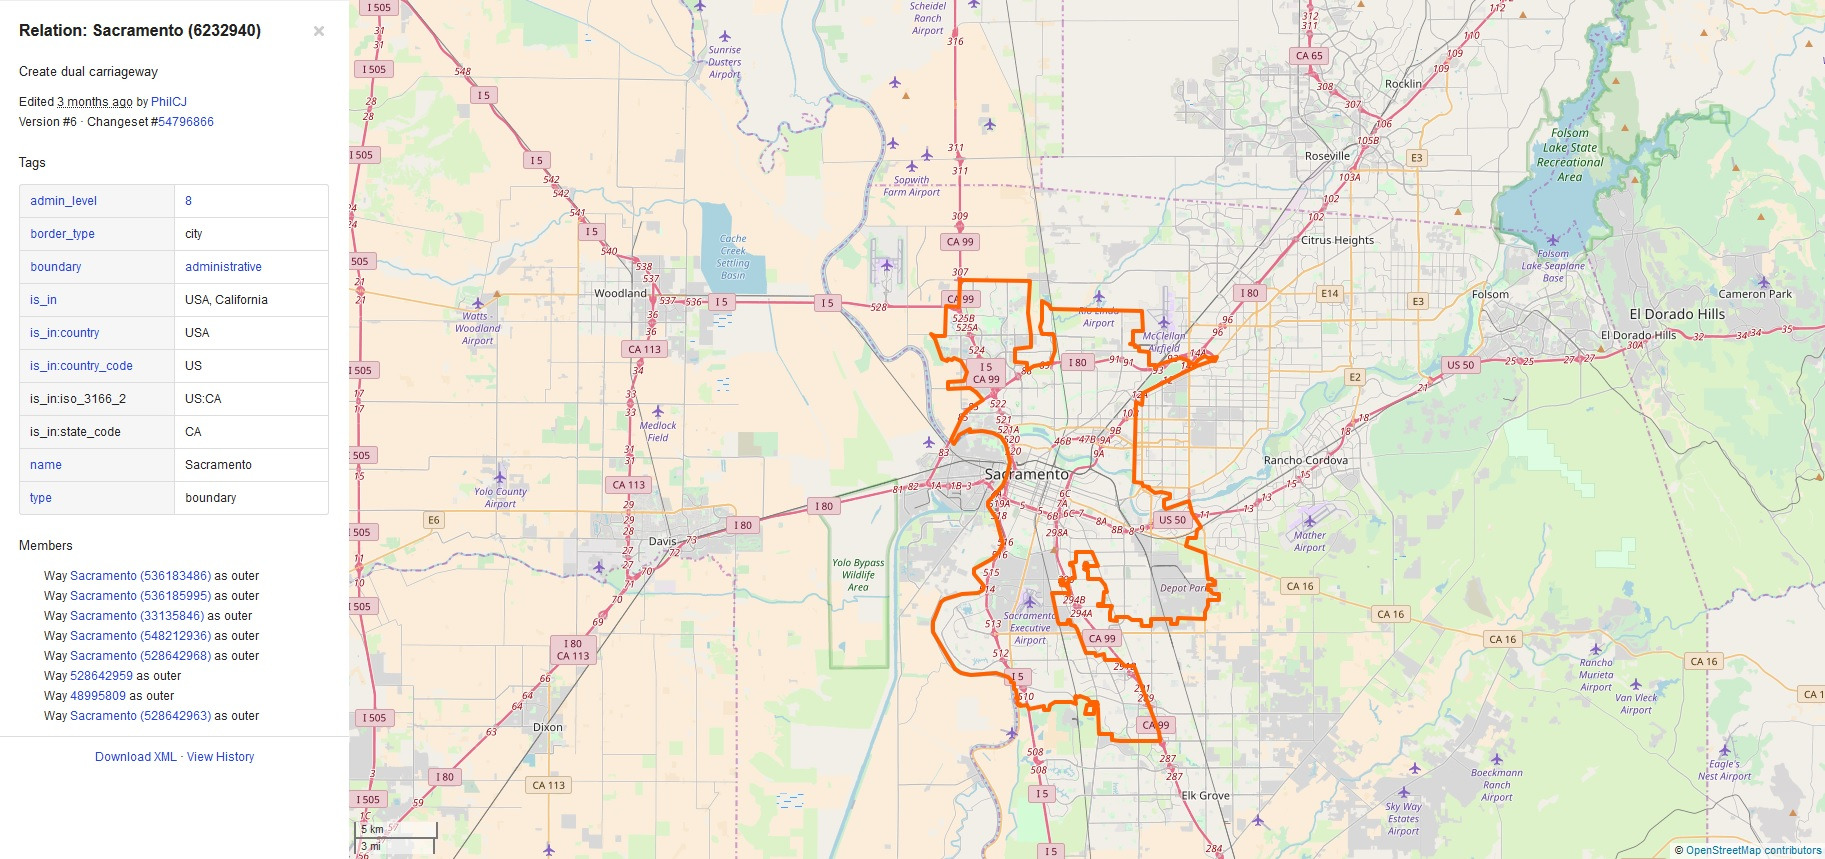

In [97]:
from IPython.display import Image
Image(filename='img1.jpg')

First, the following libraries need to be imported:

In [242]:
import os
import os.path
import sys
import time
import requests
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
from collections import defaultdict

<h2>Generate The Sample Dataset</h2>

Here you can see the size of the dataset is about 35.2 MB. First, we need to download the map data using the Overpass API (from OpenStreetMap). The function download_file() takes in the API url and the desired filename, and downloads the map data to the current worked directory. 

In [244]:
url = 'https://overpass-api.de/api/map?bbox=-121.6653,38.4326,-121.2578,38.6906'
filename = 'sacramento.osm'

In [245]:
def download_file(url, local_filename):
    # stream = True allows downloading of large files; prevents loading entire file into memory
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
                
download_file(url, filename)

<h2>Data Auditing</h2>

In order to audit the dataset and see if there is any potential problems, let's determine the number of elements and the number they occur. This will help us get a better idea of how much of what data is expected. 

Here, the count_tag function is used to return a dict with the tag as the key and the occurrence as the value. 

In [246]:
tags = {}

for event, elem in ET.iterparse(filename):
    if elem.tag in tags: tags[elem.tag] += 1
    else:                tags[elem.tag] = 1

pprint.pprint(tags)

{'bounds': 1,
 'member': 20893,
 'meta': 1,
 'nd': 602460,
 'node': 492602,
 'note': 1,
 'osm': 1,
 'relation': 1754,
 'tag': 399556,
 'way': 78506}


These elements: osm, note, and meta, contain meta of the osm file.
<p>These elements: node, way, and relation, are the basic components of the OpenStreetMap's conceptual data model of the physical world.</p>

Now, we'll check the 'k' value for every tag for three regular expressions: 
- lower: for lowercase letters only that are valid.
- lower_color: for tags with a colon in their names and are valid. 
- lower_dot: for tags that have a dot. 
Then through the count_keys function we'll return a count of each of the four tag categories in a dictionary.

In [247]:
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        for tag in element.iter('tag'):
            k = tag.get('k')
            if lower.search(k):
                keys['lower'] += 1
            elif lower_colon.search(k):
                keys['lower_colon'] += 1
            elif problemchars.search(k):
                keys['problemchars'] += 1
            else:
                keys['other'] += 1
        
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

keys = process_map(filename)
pprint.pprint(keys)

{'lower': 179479, 'lower_colon': 216234, 'other': 3843, 'problemchars': 0}


<h2>Problem 1: Inconsistent Postal Codes</h2>

Below, we use the count_postcodes function to look at the number of postcodes there are, the occurence of each, and the postcode format. 

For the most part, the zip codes are largely consistent. Although there are a few zip codes that are in a 9 digit format; and some zip codes with the string 'CA' in front. 

In [248]:
filename = open("sacramento.osm", "r")

zip_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

zip_types = defaultdict(set)

expected_zip = {}

def audit_zip_codes(zip_types, zip_name, regex, expected_zip):
    m = regex.search(zip_name)
    if m:
        zip_type = m.group()
        if zip_type not in expected_zip:
             zip_types[zip_type].add(zip_name)

def is_zip_name(elem):
    return (elem.attrib['k'] == "addr:postcode")


def audit(filename, regex):
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == "way" or elem.tag == "node":
            for tag in elem.iter("tag"):
                if is_zip_name(tag):
                    audit_zip_codes(zip_types, tag.attrib['v'], regex, expected_zip)
    pprint.pprint(dict(zip_types))

audit(filename, zip_type_re)

{'2557': set(['2557']),
 '85834': set(['85834']),
 '95501': set(['95501']),
 '95605': set(['95605']),
 '95608': set(['95608']),
 '95609-0579': set(['95609-0579']),
 '95610': set(['95610']),
 '95618': set(['95618']),
 '95621': set(['95621']),
 '95624': set(['95624']),
 '95628': set(['95628', 'CA 95628']),
 '95652': set(['95652']),
 '95655': set(['95655', 'CA 95655']),
 '95660': set(['95660']),
 '95670': set(['95670']),
 '95673': set(['95673']),
 '95691': set(['95691']),
 '95742': set(['95742']),
 '95758': set(['95758']),
 '95811': set(['95811']),
 '95814': set(['95814']),
 '95815': set(['95815']),
 '95816': set(['95816']),
 '95817': set(['95817']),
 '95818': set(['95818']),
 '95819': set(['95819', 'CA 95819']),
 '95819-6024': set(['95819-6024']),
 '95819-6055': set(['95819-6055']),
 '95819-6138': set(['95819-6138']),
 '95820': set(['95820']),
 '95821': set(['95821']),
 '95822': set(['95822', 'CA 95822']),
 '95823': set(['95823']),
 '95824': set(['95824']),
 '95825': set(['95825']),
 '95

In [249]:
def clean_zip(zip_types):
    for zip_type, ways in zip_types.iteritems(): 
            for name in ways:
                if len(name) <= 4:
                    name = ''
                if "-" in name:
                    name = name.split("-")[0].strip()
                if "CA" in name:
                    name = name.split("CA")[1].strip('CA ')
                print name
            
clean_zip(zip_types)

95838
95501
95828
95832
95832
95833
95833
95831
95837
95834
95834
95835
95819
95624
95621
95628
95628
95608
95660
95609
96816
95605
95742
95842
95826
95819
95829
95829
95864
95841
95691
95821
95820
95823
95822
95822
95825
95824
95827
95827
95826
95826
95819
95832
95618
95655
95655
95652
98584

95610
95758
95670
85834
95673
95811
95814
95815
95816
95817
95818
95819
95819


<h2>Problem 2: Abbreviated Street Names</h2>

By looking through the dataset, there are inconsistencies in the street name abbreviations. 

The goal is to unify the street types to a single representation:

- 21st St. => 21st Street
- 2nd St Suite 330 => 2nd Street

In order to do this we've set a variable mapping which mirrors the changes to fix the inconsistencies of the street types. 

The <em>update_name()</em> function fixes the street name. It takes in a string (the street name to be fixed) as an argument and returns the corresponding fix from mapping.


In [250]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
filename = open("sacramento.osm", "r")

expected_street_types = ["Avenue", "Boulevard", "Commons", "Court", "Drive", "Lane", "Parkway", 
                         "Place", "Road", "Square", "Street", "Trail", "Route", "El", "Upper", "Point", "Interchange"]

def audit_street_type(street_types, street_name, regex, expected_street_types):
    m = regex.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected_street_types:
            street_types[street_type].add(street_name)
            
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(filename, regex):  
    # iteratively parse the mapping xml
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(filename, events=("start",)):
        # iterate 'tag' tags within 'node' and 'way' tags
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'], regex, expected_street_types)
    
    return street_types
    
street_types = audit(filename, street_type_re)
pprint.pprint(dict(street_types))

{'310': set(['Greenback Lane, Suite 310']),
 '330': set(['2nd St Suite 330']),
 '5': set(['2nd St/Rte 5']),
 '50': set(['3rd St / Rte 50']),
 '95628-7416': set(['Fair Oaks Boulevard, Fair Oaks, CA 95628-7416']),
 '99': set(['13th Ave Rte 99', '47th Avenue / Rte 99']),
 'Alley': set(['Del Paso Boulevard el Monte Avenue Alley']),
 'Arena': set(['Arena']),
 'Auburn': set(['Auburn']),
 'Ave': set(['Auburn Ave',
             'Manzanita Ave',
             'Ne Quad Enterprise Dr / I-80 Ic @ Capitol Ave',
             'Norris Ave',
             'Pasadena Ave']),
 'Ave.': set(['Auburn Ave.',
              'Myrtle Ave.',
              'Norris Ave.',
              'Orange Grove Ave.',
              'Pasadena Ave.',
              'Watt Ave.']),
 'B': set(['J Street Suite B']),
 'Blvd': set(['6010 Folsom Blvd',
              'Arena Blvd',
              'Auburn Blvd',
              'Fair Oaks Blvd',
              'Folsom Blvd',
              'Franklin Blvd',
              'Freeport Blvd',
          

In [251]:
def update_name(name, mapping, regex):
    m = regex.search(name)
    if m:
        street_type = m.group()
        if street_type in mapping:
            name = re.sub(regex, mapping[street_type], name)

    return name

In [279]:
street_type_mapping = {'Ave'      : 'Avenue',
                       'Ave.'     : 'Avenue',
                       'Blvd'     : 'Boulevard',
                       'Blvd.'    : 'Boulevard',
                       'Dr'       : 'Drive',
                       'Dr.'      : 'Drive',
                       'Ln'       : 'Lane',
                       'Ln.'      : 'Lane',
                       'Pkwy'     : 'Parkway',
                       'Rd'       : 'Road',
                       'Rd.'      : 'Road',
                       'St'       : 'Street',
                       'St.'      : 'Street',
                       'ST'       : 'Street',
                       'Rte'      : 'Route',
                       'street'   : 'Street',
                       'Boulevar' : 'Boulevard',
                       'Ct.'      : 'Court',
                       'CT'       : 'Court',
                       'PKWY'     : 'Parkway', 
                       'Ic'       : 'Interchange',
                       'Uppr'     : 'Upper',
                       'Pt'       : 'Point'}

street_type_re  = re.compile(r'\b\S+\.?$', re.IGNORECASE)

for street_type, ways in street_types.iteritems():
    for name in ways:
        if name.endswith('Z'):
            name = name.replace('Z', '')
        if name.endswith('z'):
            name = name.replace('z', '')
        if name.islower():
            name = name.title()
        if '@' in name:
            name = name.replace('@ ', '')

        better_name = update_name(name, street_type_mapping, street_type_re)
        
        if name != better_name:
            print name, "=>", better_name

Greenback Ln => Greenback Lane
Hamilton St. => Hamilton Street
Paladena St. => Paladena Street
Pasadena St. => Pasadena Street
21st St. => 21st Street
Truxel Rd => Truxel Road
S. Power Inn Rd => S. Power Inn Road
Jackson Rd => Jackson Road
Florin Rd => Florin Road
S street => S Street
Zinfandel Dr. => Zinfandel Drive
College Oak Dr. => College Oak Drive
Garden Oak Ct. => Garden Oak Court
Freeport Blvd Uppr => Freeport Blvd Upper
Creek Rd. => Creek Road
Southport P PKWY => Southport P Parkway
Ponderay Ln. => Ponderay Lane
Carle Ln. => Carle Lane
Isles CT => Isles Court
Auburn Ave. => Auburn Avenue
Myrtle Ave. => Myrtle Avenue
Norris Ave. => Norris Avenue
Pasadena Ave. => Pasadena Avenue
Orange Grove Ave. => Orange Grove Avenue
Watt Ave. => Watt Avenue
Pasadena Ave => Pasadena Avenue
Manzanita Ave => Manzanita Avenue
Auburn Ave => Auburn Avenue
Norris Ave => Norris Avenue
Ne Quad Enterprise Dr / I-80 Ic Capitol Ave => Ne Quad Enterprise Dr / I-80 Ic Capitol Avenue
Northgate Blvd. => Nort

In [281]:
filename = open("sacramento.osm", "r")

cardinal_mapping = {'E'  : 'East',
                    'E.' : 'East',
                    'N'  : 'North',
                    'N.' : 'North',
                    'Ne' : 'Northeast',
                    'S'  : 'South',
                    'S.' : 'South',
                    'Sw ': 'Southwest',
                    'W'  : 'West',
                    'W.' : 'West'}

street_type_pre = re.compile(r'^[NSEeWw]\b\.?', re.IGNORECASE)

cardinal_directions =  audit(filename,street_type_pre)

for cardinal_direction, ways in cardinal_directions.iteritems():
    if cardinal_direction in cardinal_mapping:
        for name in ways:
            better_name = update_name(name, street_type_mapping, street_type_re)
            best_name   = update_name(better_name, cardinal_mapping, street_type_pre)
            if better_name != best_name:
                print name, "=>", better_name, "=>", best_name

E Street => E Street => East Street
E Street at 29th Street => E Street at 29th Street => East Street at 29th Street
N. Market Blvd => N. Market Boulevard => North Market Boulevard
N Bend Dr => N Bend Drive => North Bend Drive
N Street => N Street => North Street
S Street => S Street => South Street
S street => S Street => South Street
S. Power Inn Rd => S. Power Inn Road => South Power Inn Road
W Street => W Street => West Street
W El Camino => W El Camino => West El Camino


<h2>Problem 3: Phone Numbers</h2>

In [150]:
filename = open("sacramento.osm", "r")

phone_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

phone_types = defaultdict(set)

expected_zip = {}

def audit_phone_num(phone_types, phone_num, regex, expected_phone):
    m = regex.search(phone_num)
    if m:
        phone_type = m.group()
        if phone_type not in expected_zip:
             phone_types[phone_type].add(phone_num)

def is_phone_num(elem):
    return (elem.attrib['k'] == "phone")


def audit(filename, regex):
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == "way" or elem.tag == "node":
            for tag in elem.iter("tag"):
                if is_phone_num(tag):
                    audit_phone_num(phone_types, tag.attrib['v'], regex, expected_zip)
    pprint.pprint(dict(phone_types))

audit(filename, phone_type_re)

{'0355': set(['+1 916 254 0355']),
 '0440': set(['916 443 0440']),
 '1-530-312-8228': set(['1-530-312-8228']),
 '1-916-226-3513': set(['+1-916-226-3513']),
 '1-916-228-2500': set(['+1-916-228-2500']),
 '1-916-331-6405': set(['+1-916-331-6405']),
 '1-916-334-9763': set(['+1-916-334-9763']),
 '1-916-339-6115': set(['+1-916-339-6115']),
 '1-916-361-0296': set(['+1-916-361-0296']),
 '1-916-373-2200': set(['+1-916-373-2200']),
 '1-916-383-1998': set(['+1-916-383-1998']),
 '1-916-394-2525': set(['+1-916-394-2525']),
 '1-916-395-4635': set(['+1-916-395-4635']),
 '1-916-427-9719': set(['+1-916-427-9719']),
 '1-916-448-1475': set(['+1-916-448-1475']),
 '1-916-515-8446': set(['+1-916-515-8446']),
 '1-916-533-0942': set(['+1-916-533-0942']),
 '1-916-534-1157': set(['+1-916-534-1157']),
 '1-916-576-6657': set(['+1-916-576-6657']),
 '1-916-621-1454': set(['+1-916-621-1454']),
 '1-916-642-9555': set(['+1-916-642-9555']),
 '1-916-665-1011': set(['+1-916-665-1011']),
 '1-916-714-5400': set(['+1-916-71

In [239]:
for phone_type, ways in phone_types.iteritems():
    for name in ways:    
        if len(name) <= 9:
            name = '916 ' + name
        if name.startswith ("1 "):
            name = name.strip("1 ")
        if "- " in name:
            name = name.replace("- ", " ")
        if "-" in name:
            name = name.replace("-", " ")
        if "(" in name:
            name = name.replace("(", "")
        if ")" in name:
            name = name.replace(")", "")
        if "." in name:
            name = name.replace(".", " ")
        if name.startswith("Phone number "):
            name = name.strip("Phone number")
        if name.startswith("+1 "):
            name = name.replace("+1 ", "")
        if name.startswith("1 "):
            name = name.replace("1 ", "")
        if name.startswith("1"):
            name = name.strip("1")
        if len(name) < 12:
            only_numbers = re.sub(r'\D', "", name)
            name = only_numbers[0:3] + " " + only_numbers[3:6] + " " + only_numbers[6:]     
        if name == 'Azul Mexican Food & Tequila Bar' or name == 'yes':
            name = ''
        
        print name

916 447 2453
916 446 5905
916 808 5291
916 706 1286
916 551 1400
916 444 6130
916 685 5656
530 312 8228
916 455 2422
888 758 4389
916 447 1855
916 966 6681
916 706 2636
916 641 6060
916 498 9224
916 278 9355
916 441 6461
916 662 7695
916 334 9763
916 923 7472
916 930 9586
916 721 1080
916 624 7700
916 440 0401
916 344 0199

916 834 8227
916 383 1998
916 443 1993
916 447 4247
916 264 2700
916 443 1453
916 448 1475
916 331 6405
916 441 0505
916 920 4680
916 444 5701
916 768 9709
916 448 1818
916 228 2500
916 444 2423
916 447 2891
916 877 5590
872 222 8747
916 443 0440
916 331 4696
916 263 6951
916 897 5020
916 455 7155
916 498 1388
916 483 9283
916 339 6115
916 533 0942
916 388 2000
916 575 2312
916 448 5841
916 395 4635
916 489 5137
916 200 6265
916 441 2372
916 481 4653
916 441 0011
916 665 1011
916 443 2862
916 688 4653
916 286 5800
916  
916 373 2200
916 723 7400
916 440 0874
916 452 2613
916 447 5956
916 920 4451
916 442 7991
916 445 0181
916 448 5688
916 442 4885
916 476 6306
916 7

<h2>Preparing the Database</h2>

Now that auditing is assumed to be complete, one must prepare to insert the information into a MongoDB. To do so, the data has to be transfer into jason documents structured like this:

    {
        "id": "2406124091",
        "type: "node",
        "visible":"true",
        "created": {
                      "version":"2",
                      "changeset":"17206049",
                      "timestamp":"2013-08-03T16:43:42Z",
                      "user":"linuxUser16",
                      "uid":"1219059"
                   },
        "pos": [41.9757030, -87.6921867],
        "address": {
                      "housenumber": "312",
                      "postcode": "95632",
                      "street": "North Pearson Street"
                   },
        "amenity": "restaurant",
        "cuisine": "mexican",
        "name": "La Taqueria",
        "phone": "916 271 5276"
    }

The transform will follow these rules:
- Process only 2 top level tags: node & way
- All node and way attributes will be turned into key/value pairs with the exception of:
    - The following attributes will be added under a key created: version, changeset, timestamp, user, uid
    - Latitude and longitude attributes should be added to a pos array (geographical indexing). These values must be floats, not strings. 
- If second level tag "k" value contains problematic characters, it should be ignored
- If second level tag "k" value starts with "addr:", it should be added to a dictionary address
- If second level tag "k" value does not start with "addr:", but contains ":", you can process it same as any other tag.
- If there is a second ":" that separates the type/direction of a street, the tag should be ignored, for example:
    <tag k="addr:housenumber" v="5158"/>
    <tag k="addr:street" v="North Lincoln Avenue"/>
    <tag k="addr:street:name" v="Lincoln"/>
    <tag k="addr:street:prefix" v="North"/>
    <tag k="addr:street:type" v="Avenue"/>
    <tag k="amenity" v="pharmacy"/>

should be turned into:

    {
      "address": {
                     "housenumber": 5158,
                     "street": "North Lincoln Avenue"
                 },
      "amenity": "pharmacy"
    }

For "way" specifically:

    <nd ref="305896090"/>
    <nd ref="1719825889"/>

should be turned into:

    {
      "node_refs": ["305896090", "1719825889"]
    }
    
A function named shape_element will be used to transform the data based on above. This function will have an update function that regexes and maps the dictionaries defined above to clean street addresses.

In [283]:
from datetime import datetime

CREATED = ["version", "changeset", "timestamp", "user", "uid"]

def shape_element(element):
    node = {}    
    if element.tag == "node" or element.tag == "way" :
        node['type'] = element.tag
        
        # Parse attributes
        for attrib in element.attrib:

            # Data creation details
            if attrib in CREATED:
                if 'created' not in node:
                    node['created'] = {}
                if attrib == 'timestamp':
                    node['created'][attrib] = datetime.strptime(element.attrib[attrib], '%Y-%m-%dT%H:%M:%SZ')
                else:
                    node['created'][attrib] = element.get(attrib)

            # Parse location
            if attrib in ['lat', 'lon']:
                lat = float(element.attrib.get('lat'))
                lon = float(element.attrib.get('lon'))
                node['pos'] = [lat, lon]

            # Parse the rest of attributes
            else:
                node[attrib] = element.attrib.get(attrib)
            
        # Process tags
        for tag in element.iter('tag'):
            key   = tag.attrib['k']
            value = tag.attrib['v']
            if not problemchars.search(key):

                # Tags with single colon and beginning with addr
                if lower_colon.search(key) and key.find('addr') == 0:
                    if 'address' not in node:
                        node['address'] = {}
                    sub_attr = key.split(':')[1]
                    if is_street_name(tag):
                        # Do some cleaning
                        better_name = update_name(name, street_type_mapping, street_type_re)
                        best_name   = update_name(better_name, cardinal_mapping, street_type_pre)
                        node['address'][sub_attr] = best_name
                    else:    
                        node['address'][sub_attr] = value

                # All other tags that don't begin with "addr"
                elif not key.find('addr') == 0:
                    if key not in node:
                        node[key] = value
                else:
                    node["tag:" + key] = value
        
        # Process nodes
        for nd in element.iter('nd'):
            if 'node_refs' not in node:
                node['node_refs'] = []
            node['node_refs'].append(nd.attrib['ref'])

        return node
    else:
        return None

Now, we must parse the XML, shape the elements, and write to JSON.

In [178]:
import json
from bson import json_util

def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)    
    with open(file_out, "wb") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            
            if el:
                if pretty:
                    fo.write(json.dumps(el, indent=2, default=json_util.default)+"\n")
                else:
                    fo.write(json.dumps(el, default=json_util.default) + "\n")

data = process_map('sacramento.osm')

<h2>Data Overview</h2>

In [284]:
filename = 'sacramento.osm'
print 'The downloaded file is {} MB'.format(os.path.getsize(filename)/1.0e6) # convert from bytes to megabytes

The downloaded file is 121.240023 MB


In [285]:
print 'The json file is {} MB'.format(os.path.getsize(filename + ".json")/1.0e6) # convert from bytes to megabytes

The json file is 198.851341 MB


In [286]:
def aggregate(db, pipeline):
    return [doc for doc in sacramento.aggregate(pipeline)]

<h2>Working with MongoDB</h2>

In [287]:
from pymongo import MongoClient

mongodb_host = 'localhost'
mongodb_port = '27017'
db_name = 'sacramento'

client = MongoClient(mongodb_host +':'+ mongodb_port)
db = client[db_name]

print db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'sacramento')


In [312]:
import subprocess

collection = filename[:filename.find('.')]

working_directory = r'"C:\\Users\\Admin\\Downloads\\'
json_file = filename + '.json"'

print working_directory + json_file

mongoimport_cmd = 'C:\\mongodb\\bin\\mongoimport.exe -h 127.0.0.1:27017 ' + \
                  '--db ' + db_name + \
                  ' --collection ' + collection + \
                  ' --file ' + working_directory + json_file

# Before importing, drop collection if it exists (i.e. a re-run)
if collection in db.collection_names():
    print 'Dropping collection: ' + collection
    db[collection].drop()
    
# Execute the co
print 'Executing: ' + mongoimport_cmd

#mongoimport_cmd = "dir"
subprocess.call(mongoimport_cmd.split())

"C:\\Users\\Admin\\Downloads\\sacramento.osm.json"
Dropping collection: sacramento
Executing: C:\mongodb\bin\mongoimport.exe -h 127.0.0.1:27017 --db sacramento --collection sacramento --file "C:\\Users\\Admin\\Downloads\\sacramento.osm.json"


0

<h2>Investigating the Data</h2>

Once imported, retrieve the collection from the database.

In [307]:
sacramento = db[collection]

<strong>Number of Elements</strong>

In [308]:
sacramento.find().count()

571077

<strong>Number of Unique Users</strong>

In [309]:
len(sacramento.distinct('created.user'))

748

<strong>Number of Nodes</strong>

In [310]:
sacramento.find({'type':'node'}).count()

492576

<strong>Number of Ways</strong>

In [311]:
sacramento.find({'type': 'way'}).count()

78501

<strong>Top 10 Contributing Users</strong>

In [216]:
top_10_users = [
    {'$group': {'_id': '$created.user', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}},
    {'$limit': 10}]
result = aggregate(db, top_10_users)
pprint.pprint(result)

[{u'_id': u'woodpeck_fixbot', u'count': 97015},
 {u'_id': u'nmixter', u'count': 55300},
 {u'_id': u'jraller', u'count': 29794},
 {u'_id': u'balcoath', u'count': 25960},
 {u'_id': u'muziriana', u'count': 23899},
 {u'_id': u'Eureka gold', u'count': 23196},
 {u'_id': u'marthaleena', u'count': 17708},
 {u'_id': u'tkmedia', u'count': 17555},
 {u'_id': u'bhavana naga', u'count': 17384},
 {u'_id': u'animeigo', u'count': 17132}]


<strong>Users Appearing Only Once</strong>

In [219]:
users_appearing_once = [
    {'$group': {'_id': '$created.user', 'count': {'$sum':1}}},
    {'$group': {'_id': '$count', 'num_users': {'$sum':1}}},
    {'$sort': {'_id': 1}},
    {'$limit': 1}]
result = aggregate(db, users_appearing_once)
pprint.pprint(result)

[{u'_id': 1, u'num_users': 111}]


<strong>Top 10 Amentities</strong>

In [218]:
most_common_amenities = [
    {'$match': {'amenity': {'$exists': 1}}},
    {'$group': {'_id': '$amenity', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}},
    {'$limit': 10}]
result = aggregate(db, most_common_amenities)
pprint.pprint(result)

[{u'_id': u'parking', u'count': 1049},
 {u'_id': u'school', u'count': 469},
 {u'_id': u'place_of_worship', u'count': 442},
 {u'_id': u'restaurant', u'count': 279},
 {u'_id': u'fast_food', u'count': 257},
 {u'_id': u'fuel', u'count': 152},
 {u'_id': u'cafe', u'count': 96},
 {u'_id': u'bank', u'count': 68},
 {u'_id': u'fire_station', u'count': 59},
 {u'_id': u'toilets', u'count': 50}]


<strong>Top 20 Food Genres</strong>

In [217]:
top_20_food_genres = [
    {'$match': {'amenity': 'restaurant', 'cuisine': {'$exists': 1}}},
    {'$group': {'_id': '$cuisine', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}},
    {'$limit': 20}]
result = aggregate(db, top_20_food_genres)
pprint.pprint(result)

[{u'_id': u'mexican', u'count': 19},
 {u'_id': u'pizza', u'count': 16},
 {u'_id': u'american', u'count': 12},
 {u'_id': u'chinese', u'count': 12},
 {u'_id': u'burger', u'count': 12},
 {u'_id': u'italian', u'count': 11},
 {u'_id': u'sandwich', u'count': 9},
 {u'_id': u'japanese', u'count': 8},
 {u'_id': u'thai', u'count': 8},
 {u'_id': u'asian', u'count': 5},
 {u'_id': u'regional', u'count': 4},
 {u'_id': u'greek', u'count': 3},
 {u'_id': u'chicken', u'count': 3},
 {u'_id': u'french', u'count': 3},
 {u'_id': u'seafood', u'count': 2},
 {u'_id': u'coffee_shop', u'count': 2},
 {u'_id': u'international', u'count': 2},
 {u'_id': u'steak_house', u'count': 2},
 {u'_id': u'vietnamese', u'count': 2},
 {u'_id': u'korean', u'count': 2}]


<strong>Top 10 Banks</strong>

In [215]:
top_10_banks = [
    {'$match': {'amenity': 'bank'}}, 
    {'$group': {'_id': '$name', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}}, 
    {'$limit': 10}]
result = aggregate(db, top_10_banks)
pprint.pprint(result)

[{u'_id': u'Chase', u'count': 15},
 {u'_id': u'Bank of America', u'count': 14},
 {u'_id': u'Wells Fargo', u'count': 10},
 {u'_id': u'US Bank', u'count': 6},
 {u'_id': u'Citibank', u'count': 5},
 {u'_id': u'Golden 1 Credit Union', u'count': 3},
 {u'_id': u'The Golden 1', u'count': 2},
 {u'_id': u'SAFE Credit Union', u'count': 1},
 {u'_id': u'Tri Counties Bank', u'count': 1},
 {u'_id': u'The Golden 1 Credit Union', u'count': 1}]


<h1>Additional Ideas</h1>

<h3>Encouraging users to be more active creators</h3>

There's a significant difference in the Sacramento dataset between the highest contributor and the 10th highest contributor in terms of contributions to the dataset. There is a 5.66 difference between the highest and 10th highest contributor. With such a disparity between the top 10 contributors, it's hard to imagine that newer users would even want to contribute. 

So, how can we increase contributions on both a large and small scale?

One of the major changes could be creating a gamification platform whether through achieving a specific challenge goal (being a top 10 contributer to a sub-amenity sub-categories, e.g. adding additional restaurants in a specific cuisine) or by rewarding you for contributing overall similar to Khan Academy (complete a certain number of exercises, and you are rewarded for it). In Open Street Map, exercises would simply be overall number of contributions with bench marks for say 10, 50, 100, 500, 1000, etc. contributions. 

There also must be a checks and balance approach that helps users understand the difference between a bad, good, great, and excellent contribution. This too can be added to the gamification platform; getting users to a higher degree of mastery in their contributions, while also helping increase the overall quality of contributions across the board. 

<h3>Improving the Contribution Map Data Documentation</h3>

To add to encouraging users to be more active creators, developing better documentation in a more step by step format can easily help users become successful sooner and faster when it comes to encouraging contributions. Part of the issue is wading through the documentation for the gist of what is needed to create a decent contribution versus having more of a road map that allows you to clearly develop your contribution skills. 

Part of the issue is documentation as it is, is heavily engrained as part of the developers tool-kit where on must learn how to wade through the information for the necessary information. Developing a simpler process of navigation, and must know steps; goes a long way in getting users motivated initially where many often crumble, especially newer users.

<h3>Standardizing Contributions</h3>

One of the issues in any Data Analysis, is the lack of standardization of data. In this case, how can Open Street Map standardize contribution inputs whether for cities, zip codes, telephone numbers, etc., to allow less data wrangling and more data analysis. 

Of course, standardizing data inputs aren't easy either, but there's certain regulations used in each country that can be followied to allows first for most contributions to be accepted. Afterwards, increased functionality can be added for more rarer input cases to be accepted. 

<h2>Conclusion</h2>

How do we not only increase contributions, but make sure those contributions are of a higher quality? 

Understanding that data is majorly affected in two ways: 
1. How does a user understand and input the data?
2. How do we want the data to be standardized for ease of analysis?

This also creates another question of: Is their a way to marry the user's understanding of input with the standard input for analysis?

People understand data different from each other, whether culturally, environmentally, socially, etc. By creating a platform that allows a user to move from their own understanding, to a more universally (or at least standardized) way of thinking in a fun and rewarding way, more than likely user contributions will go up and user retention will increase. 